# 3.1 New Embodiment Finetuning Tutorial (Python API)

This provides a step-by-step guide on how to finetune GR00T-N1.5 with our python API, the G1 Block Stacking Dataset is used as an example.

This is a more detailed version of the [3_0_new_embodiment_finetuning.md](3_0_new_embodiment_finetuning.md) tutorial, which explains in-depth the details of configuring the dataset, transforms, and finetuning.


---

## Step 1: Dataset

Loading any dataset for finetuning can be done in 2 steps:
- 1.1: Defining the modality configs and transforms for the dataset
- 1.2: Loading the dataset using the `LeRobotSingleDataset` class

### Step: 1.0 Download the dataset

- Download the dataset from: https://huggingface.co/datasets/unitreerobotics/G1_BlockStacking_Dataset
- copy over the `examples/unitree_g1_blocks__modality.json` to the dataset `<DATASET_PATH>/meta/modality.json`
  - This provides additional information about the state and action modalities to make it "GR00T-compatible"
  - `cp examples/unitree_g1_blocks__modality.json datasets/G1_BlockStacking_Dataset/meta/modality.json`


**Understanding the Modality Configs**

This file provides detailed metadata about state and action modalities, enabling:

- **Separate Data Storage and Interpretation:**
  - **State and Action:** Stored as concatenated float32 arrays. The `modality.json` file supplies the metadata necessary to interpret these arrays as distinct, fine-grained fields with additional training information.
  - **Video:** Stored as separate files, with the configuration file allowing them to be renamed to a standardized format.
  - **Annotations:** Keeps track of all annotation fields. If there are no annotations, do not include the `annotation` field in the configuration file.
- **Fine-Grained Splitting:** Divides the state and action arrays into more semantically meaningful fields.
- **Clear Mapping:** Explicit mapping of data dimensions.
- **Sophisticated Data Transformations:** Supports field-specific normalization and rotation transformations during training.

#### Schema

```json
{
    "state": {
        "<state_name>": {
            "start": <int>,         // Starting index in the state array
            "end": <int>,           // Ending index in the state array
        }
    },
    "action": {
        "<action_name>": {
            "start": <int>,         // Starting index in the action array
            "end": <int>,           // Ending index in the action array
        }
    },
    "video": {
        "<video_name>": {}  // Empty dictionary to maintain consistency with other modalities
    },
    "annotation": {
        "<annotation_name>": {}  // Empty dictionary to maintain consistency with other modalities
    }
}
```

Example is shown in `getting_started/examples/unitree_g1_blocks__modality.json`. This file is located in the `meta` folder of the lerobot dataset.


Generate the Stats (`meta/metadata.json`) by running the following command:
```bash
python scripts/load_dataset.py --data_path /datasets/G1_BlockStacking_Dataset/ --embodiment_tag new_embodiment
```

In [16]:
from gr00t.data.schema import EmbodimentTag

In [17]:
import os
print("Current working directory:", os.getcwd())

# 使用绝对路径确保能找到数据集
dataset_path = "/Users/apple/Documents/Isaac-GR00T/demo_data/pick增强"  # 绝对路径
print("Dataset path:", dataset_path)
print("Path exists:", os.path.exists(dataset_path))

embodiment_tag = EmbodimentTag.NEW_EMBODIMENT

Current working directory: /Users/apple/Documents/Isaac-GR00T/getting_started
Dataset path: /Users/apple/Documents/Isaac-GR00T/demo_data/pick增强
Path exists: True


### Step: 1.1 Modality configs and transforms

Modality configs let you select which specific data streams to use for each input type (video, state, action, language, etc.) during finetuning, giving you precise control over which parts of your dataset are utilized.

In [18]:
from gr00t.data.dataset import ModalityConfig


# select the modality keys you want to use for finetuning
video_modality = ModalityConfig(
    delta_indices=[0],
    modality_keys=["video.front"],  # 使用实际存在的视频键
)

state_modality = ModalityConfig(
    delta_indices=[0],
    modality_keys=["state.single_arm", "state.gripper"],  # 使用实际存在的状态键
)

action_modality = ModalityConfig(
    delta_indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    modality_keys=["action.single_arm", "action.gripper"],  # 使用实际存在的动作键
)

language_modality = ModalityConfig(
    delta_indices=[0],
    modality_keys=["annotation.human.task_description"],
)

modality_configs = {
    "video": video_modality,
    "state": state_modality,
    "action": action_modality,
    "language": language_modality,
}

print("Updated modality configurations:")
print(f"  Video: {video_modality.modality_keys}")
print(f"  State: {state_modality.modality_keys}")
print(f"  Action: {action_modality.modality_keys}")
print(f"  Language: {language_modality.modality_keys}")

Updated modality configurations:
  Video: ['video.front']
  State: ['state.single_arm', 'state.gripper']
  Action: ['action.single_arm', 'action.gripper']
  Language: ['annotation.human.task_description']


In [19]:
from gr00t.data.transform.base import ComposedModalityTransform
from gr00t.data.transform import VideoToTensor, VideoCrop, VideoResize, VideoColorJitter, VideoToNumpy
from gr00t.data.transform.state_action import StateActionToTensor, StateActionTransform
from gr00t.data.transform.concat import ConcatTransform
from gr00t.model.transforms import GR00TTransform


# select the transforms you want to apply to the data
to_apply_transforms = ComposedModalityTransform(
    transforms=[
        # video transforms
        VideoToTensor(apply_to=video_modality.modality_keys, backend="torchvision"),
        VideoCrop(apply_to=video_modality.modality_keys, scale=0.95, backend="torchvision"),
        VideoResize(apply_to=video_modality.modality_keys, height=224, width=224, interpolation="linear", backend="torchvision" ),
        VideoColorJitter(apply_to=video_modality.modality_keys, brightness=0.3, contrast=0.4, saturation=0.5, hue=0.08, backend="torchvision"),
        VideoToNumpy(apply_to=video_modality.modality_keys),

        # state transforms
        StateActionToTensor(apply_to=state_modality.modality_keys),
        StateActionTransform(apply_to=state_modality.modality_keys, normalization_modes={
            "state.single_arm": "min_max",
            "state.gripper": "min_max",
        }),

        # action transforms
        StateActionToTensor(apply_to=action_modality.modality_keys),
        StateActionTransform(apply_to=action_modality.modality_keys, normalization_modes={
            "action.single_arm": "min_max",
            "action.gripper": "min_max",
        }),

        # ConcatTransform
        ConcatTransform(
            video_concat_order=video_modality.modality_keys,
            state_concat_order=state_modality.modality_keys,
            action_concat_order=action_modality.modality_keys,
        ),
        # model-specific transform
        GR00TTransform(
            state_horizon=len(state_modality.delta_indices),
            action_horizon=len(action_modality.delta_indices),
            max_state_dim=64,
            max_action_dim=32,
        ),
    ]
)

print("Transforms configured for:")
print(f"  Video keys: {video_modality.modality_keys}")
print(f"  State keys: {state_modality.modality_keys}")
print(f"  Action keys: {action_modality.modality_keys}")


Transforms configured for:
  Video keys: ['video.front']
  State keys: ['state.single_arm', 'state.gripper']
  Action keys: ['action.single_arm', 'action.gripper']


### Step 1.2 Load the dataset

First we will visualize the dataset and then load it using the `LeRobotSingleDataset` class. (without transforms)

In [20]:
from gr00t.data.dataset import LeRobotSingleDataset

train_dataset = LeRobotSingleDataset(
    dataset_path=dataset_path,
    modality_configs=modality_configs,
    embodiment_tag=embodiment_tag,
    video_backend="torchvision_av",
)


Initialized dataset pick增强 with EmbodimentTag.NEW_EMBODIMENT


Dataset sample keys: dict_keys(['video.front', 'state.single_arm', 'state.gripper', 'action.single_arm', 'action.gripper', 'annotation.human.task_description'])
Video data shape: (1, 1080, 1920, 3)
Video data type: <class 'numpy.ndarray'>


/opt/anaconda3/envs/Isaac-GR00T/lib/python3.10/site-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
/opt/anaconda3/envs/Isaac-GR00T/lib/python3.10/site-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
/opt/anaconda3/envs/Isaac-GR00T/lib/python3.10/site-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding

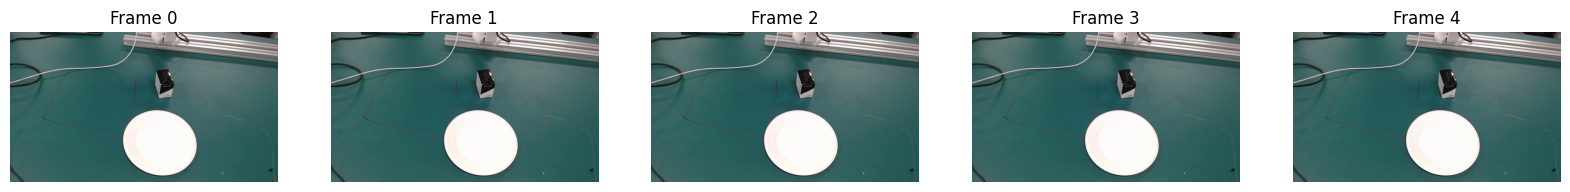

In [21]:
# use matplotlib to visualize the images
import matplotlib.pyplot as plt
import numpy as np

print("Dataset sample keys:", train_dataset[0].keys())

# 检查视频数据的结构
sample = train_dataset[0]
video_key = "video.front"  # 使用实际存在的视频键
print(f"Video data shape: {sample[video_key].shape}")
print(f"Video data type: {type(sample[video_key])}")

images = []
for i in range(5):
    image = train_dataset[i][video_key][0]  # 使用正确的视频键
    # image is in HWC format, convert it to CHW format
    image = image.transpose(2, 0, 1)
    images.append(image)   

fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i, image in enumerate(images):
    axs[i].imshow(np.transpose(image, (1, 2, 0)))
    axs[i].axis("off")
    axs[i].set_title(f"Frame {i}")
plt.show()

Now, we will initiate a dataset with our modality configs and transforms.

In [22]:
train_dataset = LeRobotSingleDataset(
    dataset_path=dataset_path,
    modality_configs=modality_configs,
    embodiment_tag=embodiment_tag,
    video_backend="torchvision_av",
    transforms=to_apply_transforms,
)

Initialized dataset pick增强 with EmbodimentTag.NEW_EMBODIMENT


**Extra Notes**:
 - We use a cached dataloader to accelerate training speed. The cached dataloader loads all data into memory, which significantly improves training performance. However, if your dataset is large or you're experiencing out-of-memory (OOM) errors, you can switch to the standard lerobot dataloader (`gr00t.data.dataset.LeRobotSingleDataset`). It uses the same API as the cached dataloader, so you can switch back and forth without any changes to your code.
 - we use torchvision_av as the video backend, the video encoding is in av instead of standard h264


### Step 2: Load the model

The training process is done in 3 steps:
- 2.1: Load the base model from HuggingFace or a local path
- 2.2: Prepare training args
- 2.3: Run the training loop

#### Step 2.1 Load the base model

We'll use the `from_pretrained_for_tuning` method to load the model. This method allows us to specify which parts of the model to tune.

In [23]:
import os
import torch

# 检查可用的设备
if torch.cuda.is_available():
    device = "cuda"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
elif torch.backends.mps.is_available():
    device = "mps"
    # 设置MPS兼容性
    torch.set_default_dtype(torch.float32)
    print("Using MPS device with float32")
else:
    device = "cpu"
    print("Using CPU device")

print(f"Selected device: {device}")

Using MPS device with float32
Selected device: mps


In [24]:
from gr00t.model.gr00t_n1 import GR00T_N1_5

BASE_MODEL_PATH = "nvidia/GR00T-N1.5-3B"
TUNE_LLM = False            # Whether to tune the LLM
TUNE_VISUAL = False          # Whether to tune the visual encoder
TUNE_PROJECTOR = True       # Whether to tune the projector
TUNE_DIFFUSION_MODEL = True # Whether to tune the diffusion model

model = GR00T_N1_5.from_pretrained(
    pretrained_model_name_or_path=BASE_MODEL_PATH,
    tune_llm=TUNE_LLM,  # backbone's LLM
    tune_visual=TUNE_VISUAL,  # backbone's vision tower
    tune_projector=TUNE_PROJECTOR,  # action head's projector
    tune_diffusion_model=TUNE_DIFFUSION_MODEL,  # action head's DiT
)

# 根据设备类型设置compute_dtype
if device == "cuda":
    model.compute_dtype = "bfloat16"
    model.config.compute_dtype = "bfloat16"
else:
    # 对于MPS和CPU，使用float32
    model.compute_dtype = "float32"
    model.config.compute_dtype = "float32"
    
model.to(device)

Loading pretrained dual brain from nvidia/GR00T-N1.5-3B
Tune backbone vision tower: False
Tune backbone LLM: False
Tune action head projector: True
Tune action head DiT: True


Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

Tune backbone llm: False
Tune backbone visual: True
Total number of DiT parameters:  550386688
Total number of SelfAttentionTransformer parameters:  201433088
Tune action head projector: True
Tune action head diffusion model: True


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Tune backbone llm: False
Tune backbone visual: False
Tune action head projector: True
Tune action head diffusion model: True


GR00T_N1_5(
  (backbone): EagleBackbone(
    (eagle_model): Eagle2_5_VLForConditionalGeneration(
      (vision_model): SiglipVisionModel(
        (vision_model): SiglipVisionTransformer(
          (embeddings): SiglipVisionEmbeddings(
            (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
            (position_embedding): Embedding(256, 1152)
          )
          (encoder): SiglipEncoder(
            (layers): ModuleList(
              (0-26): 27 x SiglipEncoderLayer(
                (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
                (self_attn): SiglipAttention(
                  (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
                  (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
                  (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
                  (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
              

#### Step 2.2 Prepare training args

We use huggingface `TrainingArguments` to configure the training process. Here are the main parameters:

**📚 训练步数 (Training Steps) 说明:**

- **1 Step = 1 Batch**: 每一步训练处理一个批次的数据
- **当前批次大小**: 2 个样本 (MPS设备优化配置)
- **数据集大小**: 约8,400帧数据

**🎯 不同训练步数的效果:**
- **20 steps**: 快速验证代码运行 (约40个样本)
- **100 steps**: 初步学习效果 (约200个样本)  
- **1,000 steps**: 显著改善效果 (约2,000个样本)
- **10,000 steps**: 高质量训练效果 (约20,000个样本)

**⏱️ 训练时间估算 (MPS设备):**
- 20 steps ≈ 1-2分钟
- 100 steps ≈ 5-10分钟
- 1,000 steps ≈ 1-2小时
- 10,000 steps ≈ 10-20小时

In [ ]:
from transformers import TrainingArguments

output_dir = "/tmp/gr00t_test"          # 使用临时目录
per_device_train_batch_size = 2 if device == "mps" else 8  # MPS使用更小的批次
max_steps = 20                          # 保持较小的步数用于测试
report_to = "wandb"
dataloader_num_workers = 0 if device == "mps" else 4  # MPS不使用多进程

# 根据设备类型设置精度
use_bf16 = device == "cuda"
use_fp16 = False
tf32 = device == "cuda"

training_args = TrainingArguments(
    output_dir=output_dir,
    run_name=None,
    remove_unused_columns=False,
    deepspeed="",
    gradient_checkpointing=False,
    bf16=use_bf16,
    fp16=use_fp16,
    tf32=tf32,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=1,
    dataloader_num_workers=dataloader_num_workers,
    dataloader_pin_memory=False,
    dataloader_persistent_workers=dataloader_num_workers > 0,
    optim="adamw_torch",
    adam_beta1=0.95,
    adam_beta2=0.999,
    adam_epsilon=1e-8,
    learning_rate=1e-4,
    weight_decay=1e-5,
    warmup_ratio=0.05,
    lr_scheduler_type="cosine",
    logging_steps=10.0,
    num_train_epochs=300,
    max_steps=max_steps,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=8,
    report_to=report_to,
    seed=42,
    do_eval=False,
    ddp_find_unused_parameters=False,
    ddp_bucket_cap_mb=100,
    torch_compile_mode=None,
)

print(f"Training configuration:")
print(f"  Device: {device}")
print(f"  Batch size: {per_device_train_batch_size}")
print(f"  Workers: {dataloader_num_workers}")
print(f"  BF16: {use_bf16}")
print(f"  Output dir: {output_dir}")


Training configuration:
  Device: mps
  Batch size: 2
  Workers: 0
  BF16: False
  Output dir: /tmp/gr00t_test


#### Step 2.3 Initialize the training runner and run the training loop

In [26]:
from gr00t.experiment.runner import TrainRunner

experiment = TrainRunner(
    train_dataset=train_dataset,
    model=model,
    training_args=training_args,
)

experiment.train()

Run name: /tmp/gr00t_test
train dataloader length: 4200
train dataset length: 8400

TensorBoard logs will be saved to: /tmp/gr00t_test/runs


/opt/anaconda3/envs/Isaac-GR00T/lib/python3.10/site-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
/opt/anaconda3/envs/Isaac-GR00T/lib/python3.10/site-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
/opt/anaconda3/envs/Isaac-GR00T/lib/python3.10/site-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding

Step,Training Loss
10,0.599800
20,0.502700


/opt/anaconda3/envs/Isaac-GR00T/lib/python3.10/site-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
/opt/anaconda3/envs/Isaac-GR00T/lib/python3.10/site-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
/opt/anaconda3/envs/Isaac-GR00T/lib/python3.10/site-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding

We can see the 1k offline validation results vs 10k offline validation results:

**Finetuning Results on Unitree G1 Block Stacking Dataset:**

| 1k Steps | 10k Steps |
| --- | --- |
| ![1k](../media/g1_ft_1k.png) | ![10k](../media/g1_ft_10k.png) |
| MSE: 0.0181 | MSE: 0.0022 |